In [140]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Informacije o podacima:**
Ovaj skup podataka sadrži preko 65 hiljada zapisa o prekršajima u saobraćaju.

Podaci o atributima:
1. stop_date - Datum prekršaja
2. stop_time - Vreme prekršaja
3. driver_gender - Pol prekršioca (Muško-M, Žensko-F)
4. driver_age - Godine prekršioca
5. driver_race - Rasa prekršioca
6. violation - Vrsta prekršaja :
    - Speeding 
    - Moving Violation (Neoprezna vožnja, Hit and run, Ugrožavanje ostalih vozača i pešaka, neoprezna skretanja i promena trake...)
    - Equipment (Zatamljena stakla, Neispravni farovi, Napukli vetrobran, etc.)
    - Registration/Plates
    - Seat Belt
    - other
7. search_conducted - Da li je došlo do pretresa nakon prekršaja
8. stop_outcome - Rezultat policijske intervencije
9. is_arrested - Da li je prekrsilac uhapšen ili ne
10. stop_duration - Vreme provedeno tokom intervencije
11. drugs_related_stop - Da li je prekršilac bio pod uticajem alkohola i opojnih droga

# Učitavanje i analiza skupa podataka

In [141]:
data = pd.read_csv('../dataset/traffic_violations.csv')
rows, columns = data.shape
print(f'Broj redova: {rows}')
print(f'Broj kolona: {columns}')
print(f'Imena atributa: {list(data.columns)}')

Broj redova: 52966
Broj kolona: 15
Imena atributa: ['stop_date', 'stop_time', 'country_name', 'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race', 'violation_raw', 'violation', 'search_conducted', 'search_type', 'stop_outcome', 'is_arrested', 'stop_duration', 'drugs_related_stop']


Pogledajmo koje su sve jedinstvene vrednosti za atribute

In [142]:
all_columns = data.columns.to_list()

for i, column in enumerate(all_columns):
    temp = data.loc[:, column].unique()
    if len(temp) == 1:
        print (f"{i+1}. {column} sadrži {len(temp)} jedinstvenu vrednost: {temp}")
    else:
        print (f"{i+1}. {column} sadrži {len(temp)} jedinstvenih vrednosti: {temp}")
del temp

1. stop_date sadrži 2223 jedinstvenih vrednosti: ['1/2/2005' '1/18/2005' '1/23/2005' ... '10/4/2011' '10/5/2011' '10/5']
2. stop_time sadrži 1428 jedinstvenih vrednosti: ['1:55' '8:15' '23:15' ... '5:51' '5:23' nan]
3. country_name sadrži 1 jedinstvenu vrednost: [nan]
4. driver_gender sadrži 3 jedinstvenih vrednosti: ['M' 'F' nan]
5. driver_age_raw sadrži 92 jedinstvenih vrednosti: [1985. 1965. 1972. 1986. 1984. 1982. 1969. 1970. 1979. 1966. 1955. 1958.
 1953. 1967.   nan 1964. 1977. 1959. 1973. 1947. 1978. 1962. 1981. 1988.
 1983. 1961. 1957. 1971. 1950. 1954. 1960. 1976. 1974. 1968. 1938. 1980.
 1963. 1975. 1987. 1948. 1956. 1944. 1935.    0. 1952. 1945. 1946. 1941.
 1942. 1951. 1949. 2005. 1939. 1943. 1936. 1924. 1937. 1929. 1930. 1931.
 1923. 1940. 1933. 1989. 1928. 1932. 1990. 1926. 2006. 1927. 1997. 1934.
 1887. 1925. 1918. 2004. 1991. 2002. 2007. 1992. 8801. 2001. 2003. 1998.
 1922. 1993. 2008. 2009. 2919. 2000. 1994. 1995.]
6. driver_age sadrži 73 jedinstvenih vrednosti: [20. 4

In [143]:
data.head()

,stop_date,stop_time,country_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,1/2/2005,1:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,1/18/2005,8:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,1/23/2005,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2/20/2005,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,3/14/2005,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52966 entries, 0 to 52965
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_date           52966 non-null  object 
 1   stop_time           52965 non-null  object 
 2   country_name        0 non-null      float64
 3   driver_gender       49580 non-null  object 
 4   driver_age_raw      49588 non-null  float64
 5   driver_age          49346 non-null  float64
 6   driver_race         49581 non-null  object 
 7   violation_raw       49581 non-null  object 
 8   violation           49581 non-null  object 
 9   search_conducted    52965 non-null  object 
 10  search_type         2085 non-null   object 
 11  stop_outcome        49581 non-null  object 
 12  is_arrested         49581 non-null  object 
 13  stop_duration       49581 non-null  object 
 14  drugs_related_stop  52965 non-null  object 
dtypes: float64(3), object(12)
memory usage: 6.1+ MB


# Rad sa nedostajućim vrednostima

Proveravamo da li u skupu postoje nedostajuće vrednosti

In [145]:
data.isna().any().any()

True

U skupu postoje nedostajuće vrednosti. Koliko ih ima?

In [146]:
data.isna().sum()

stop_date                 0
stop_time                 1
country_name          52966
driver_gender          3386
driver_age_raw         3378
driver_age             3620
driver_race            3385
violation_raw          3385
violation              3385
search_conducted          1
search_type           50881
stop_outcome           3385
is_arrested            3385
stop_duration          3385
drugs_related_stop        1
dtype: int64

## Izbacivanje nedostajućih vrednosti

**Atributi country_name i search_type sadrže skoro sve NaN vrednosti, pa ćemo ih izbaciti**

Ostali atributi imaju sličnu reprezentaciju podataka, pa ćemo eliminisati redove koje sadrže nedostajuće vrednosti.

In [147]:
data.drop(columns = ['country_name','search_type'], inplace=True)
data.dropna(subset = ['driver_gender'], inplace = True)

In [148]:
data.isna().sum()

stop_date               0
stop_time               0
driver_gender           0
driver_age_raw          0
driver_age            240
driver_race             0
violation_raw           0
violation               0
search_conducted        0
stop_outcome            0
is_arrested             0
stop_duration           0
drugs_related_stop      0
dtype: int64

U atributu driver_age postoje nedostajuće vrednosti. Popunićemo ih sa medijanom.

Nakon obrade, proveravamo da li je ostalo nedostajućih vrednosti.

In [149]:
data['driver_age'] = data['driver_age'].fillna(data.groupby('driver_gender')['driver_age'].transform('median'))
data.isna().any().any()

False

Sada smo spremni za dalju analizu.

Umesto jednog atributa koji nam daje informacije o datumu, napravićemo tri nova atributa.
Razlog za to je format Timestamp koji nam ne odgovar za naredne korake.

In [150]:
data['stop_year'] = data['stop_date'].apply(lambda x: int(x.split('/')[2]))
data['stop_month'] = data['stop_date'].apply(lambda x: int(x.split('/')[0]))
data['stop_day'] = data['stop_date'].apply(lambda x: int(x.split('/')[1]))
data.drop('stop_date', axis=1, inplace=True)
data.head()

,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_month,stop_day
0,1:55,M,1985.0,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,2
1,8:15,M,1965.0,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,18
2,23:15,M,1972.0,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,23
3,17:15,M,1986.0,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,2005,2,20
4,10:00,F,1984.0,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,3,14


Ponavljamo postupak za atribut stop_time

In [151]:
data['stop_time'] = data['stop_time'].apply(lambda x: int(x.split(':')[0]) + int(x.split(':')[1])/60)
data.head()

,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_month,stop_day
0,1.916667,M,1985.0,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,2
1,8.250000,M,1965.0,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,18
2,23.250000,M,1972.0,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,23
3,17.250000,M,1986.0,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,2005,2,20
4,10.000000,F,1984.0,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,3,14


Kolonu za pol prekršioca ćemo kodirati sa 0 za osobe ženskog pola i sa 1 za osobe muškog pola.

In [152]:
data['driver_gender'] = data['driver_gender'].map({'M':0,'F':1})
data.head()

,stop_time,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_month,stop_day
0,1.916667,0,1985.0,20.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,2
1,8.250000,0,1965.0,40.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,18
2,23.250000,0,1972.0,33.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,1,23
3,17.250000,0,1986.0,19.0,White,Call for Service,Other,False,Arrest Driver,True,16-30 Min,False,2005,2,20
4,10.000000,1,1984.0,21.0,White,Speeding,Speeding,False,Citation,False,0-15 Min,False,2005,3,14


Atribut driver_age_raw nam govori istu stvar kao i atribut driver_age, pa ćemo ga ukloniti.

Medjutim, atribut violation_raw daje opsirnije informacije u odnosu na atribut violation, pa ćemo atribut violation zameniti sa atributom violation_raw, a atribut violation_raw ćemo ukloniti.

In [153]:
data.drop('driver_age_raw', axis=1, inplace=True)
data['violation'] = data['violation_raw'].apply(lambda x: x)
data.drop('violation_raw', axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49580 entries, 0 to 52964
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_time           49580 non-null  float64
 1   driver_gender       49580 non-null  int64  
 2   driver_age          49580 non-null  float64
 3   driver_race         49580 non-null  object 
 4   violation           49580 non-null  object 
 5   search_conducted    49580 non-null  object 
 6   stop_outcome        49580 non-null  object 
 7   is_arrested         49580 non-null  object 
 8   stop_duration       49580 non-null  object 
 9   drugs_related_stop  49580 non-null  object 
 10  stop_year           49580 non-null  int64  
 11  stop_month          49580 non-null  int64  
 12  stop_day            49580 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 5.3+ MB


Slicno, kodiramo vrednosti atributa search_conducted sa 1 ukoliko je došlo do pretresa, a sa 0 inače.

In [154]:
data['search_conducted'] = data['search_conducted'].apply(lambda x: 1 if x == True else 0)
data.head()

,stop_time,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_month,stop_day
0,1.916667,0,20.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,1,2
1,8.250000,0,40.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,1,18
2,23.250000,0,33.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,1,23
3,17.250000,0,19.0,White,Call for Service,0,Arrest Driver,True,16-30 Min,False,2005,2,20
4,10.000000,1,21.0,White,Speeding,0,Citation,False,0-15 Min,False,2005,3,14


Ponavljamo postupak za kolonu is_arrested, tako da je vrednost 0 ako osoba nije uhapšena, a 1 inače.

In [155]:
data['is_arrested'] = data['is_arrested'].apply(lambda x: 1 if x == True else 0)
data.head()

,stop_time,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_month,stop_day
0,1.916667,0,20.0,White,Speeding,0,Citation,0,0-15 Min,False,2005,1,2
1,8.250000,0,40.0,White,Speeding,0,Citation,0,0-15 Min,False,2005,1,18
2,23.250000,0,33.0,White,Speeding,0,Citation,0,0-15 Min,False,2005,1,23
3,17.250000,0,19.0,White,Call for Service,0,Arrest Driver,1,16-30 Min,False,2005,2,20
4,10.000000,1,21.0,White,Speeding,0,Citation,0,0-15 Min,False,2005,3,14


Isto za atribut drug_related_stop.

In [156]:
data['drugs_related_stop'] = data['drugs_related_stop'].apply(lambda x: 1 if x == True else 0)
data.head()

,stop_time,driver_gender,driver_age,driver_race,violation,search_conducted,stop_outcome,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_month,stop_day
0,1.916667,0,20.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,1,2
1,8.250000,0,40.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,1,18
2,23.250000,0,33.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,1,23
3,17.250000,0,19.0,White,Call for Service,0,Arrest Driver,1,16-30 Min,0,2005,2,20
4,10.000000,1,21.0,White,Speeding,0,Citation,0,0-15 Min,0,2005,3,14


In [157]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49580 entries, 0 to 52964
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_time           49580 non-null  float64
 1   driver_gender       49580 non-null  int64  
 2   driver_age          49580 non-null  float64
 3   driver_race         49580 non-null  object 
 4   violation           49580 non-null  object 
 5   search_conducted    49580 non-null  int64  
 6   stop_outcome        49580 non-null  object 
 7   is_arrested         49580 non-null  int64  
 8   stop_duration       49580 non-null  object 
 9   drugs_related_stop  49580 non-null  int64  
 10  stop_year           49580 non-null  int64  
 11  stop_month          49580 non-null  int64  
 12  stop_day            49580 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 5.3+ MB


 ## Raspodela godina

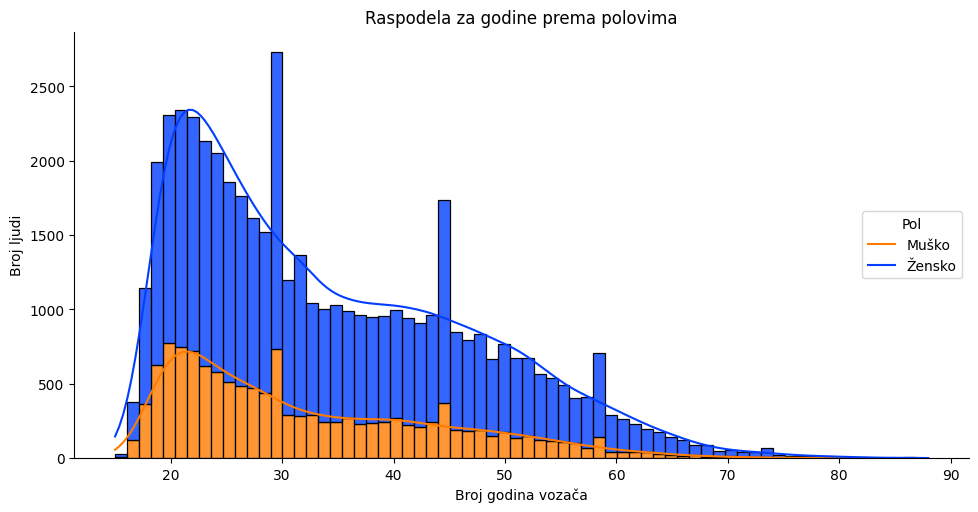

In [158]:
g = sns.displot(x = 'driver_age', hue = 'driver_gender', kde = True, data = data, 
            multiple = 'stack', alpha = 0.8, palette = "bright", height=5, aspect=2)
g._legend.remove()
plt.legend(title = 'Pol', labels = ['Muško', 'Žensko'], loc = 'center right')
plt.title('Raspodela za godine prema polovima')
plt.xlabel("Broj godina vozača")
plt.ylabel("Broj ljudi");

Možemo primetiti da i muški i ženski vozači starosti između 20 i 40 godina čine maksimalne prekršaje, dok osobe starije od 50 godina čine minimalno. Takodje, vidimo da trend prekršaja i starosne grupe za jednu polnu grupu sledi iz druge. 

To znaci da su prekršaji nezavisni od pola osobe, što je i očigledno imajući u vidu sve ostale parametre.

## Odnos godina vozača i tipa prekršaja koji su počinili

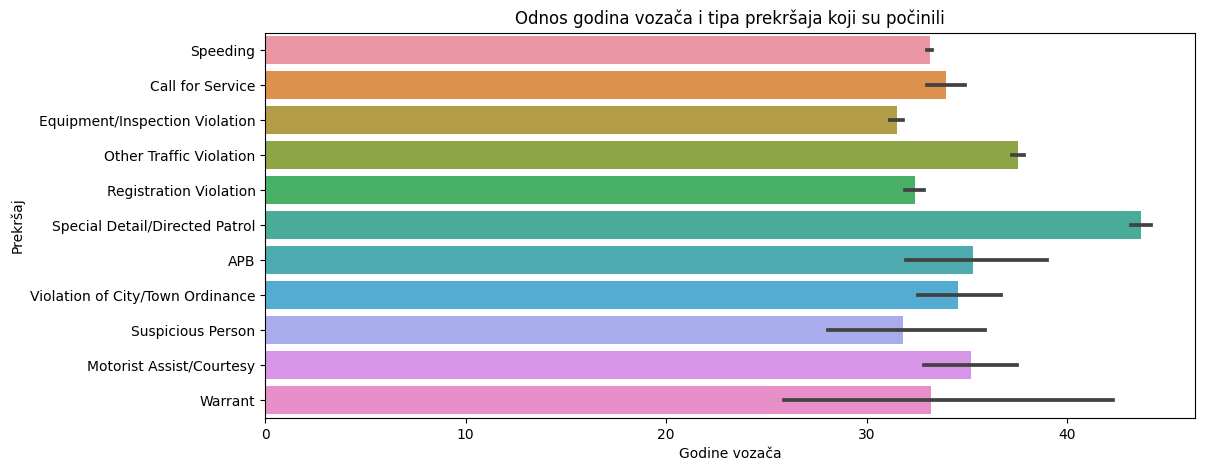

In [159]:
plt.figure(figsize=(12,5))
sns.barplot(x='driver_age', y='violation', data=data)
plt.title('Odnos godina vozača i tipa prekršaja koji su počinili')
plt.ylabel('Prekršaj')
plt.xlabel('Godine vozača')
plt.show()

## Raspodela tipa prekršaja

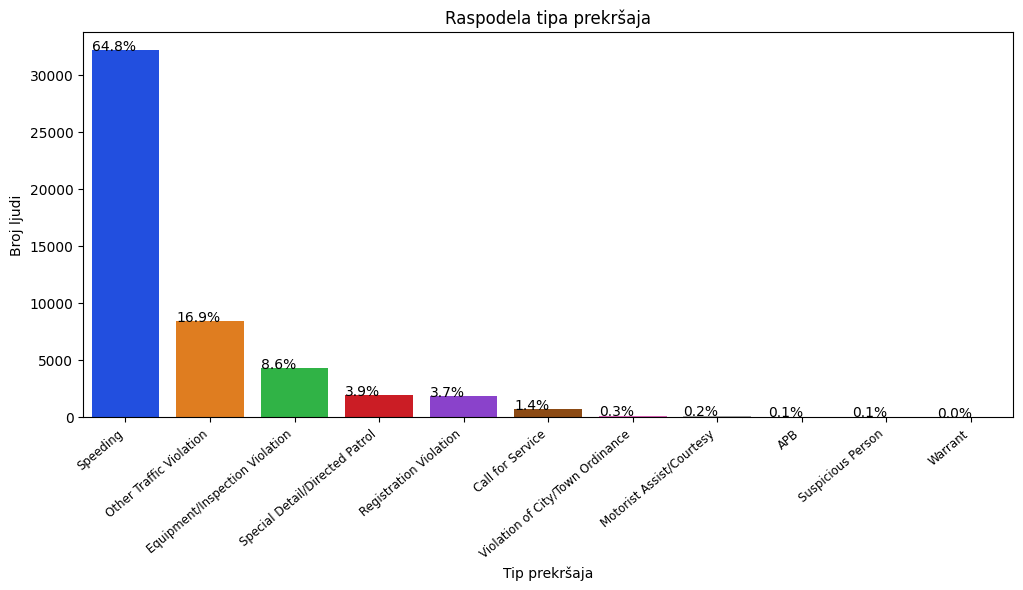

In [160]:
fig , ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x = data.violation, data = data, order = data.violation.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.violation))
    x = i.get_x()
    y = i.get_height()
    ax.annotate(percentage, (x, y))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 8.5)
plt.title("Raspodela tipa prekršaja")
plt.xlabel("Tip prekršaja")
plt.ylabel("Broj ljudi");

**Ubedljivo, prekršaji u saobraćaju, prema datom skupu podataka, najviše nastaju zbog prekoračenja dozvoljene brzine. Čak 64.8% od svih ostalih razloga zbog kojeg je nastao prekršaj.**

## Odnos rase i broja prekršaja

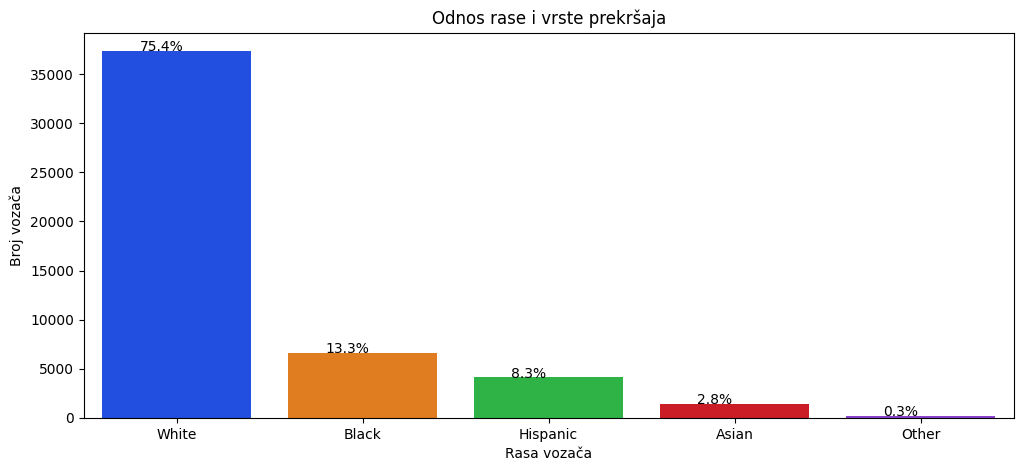

In [161]:
fig , ax = plt.subplots(figsize = (12,5))
ax = sns.countplot(x='driver_race', data=data, order = data.driver_race.value_counts().index,
                   linewidth = 0, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.driver_race))
    x = i.get_x()+i.get_width()-0.6
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('Odnos rase i vrste prekršaja')
plt.xlabel("Rasa vozača")
plt.ylabel("Broj vozača");

Sa grafika možemo primetiti da belci, crnci i hispanci čine oko 97 % saobraćajnih prekršaja (na osnovu skupa podataka sa kojim raspolažemo), a među njima pripadnici bele rase zauzimaju čak 75.4 %. 

Vrlo očigledan razlog za ovo može biti raspodela stanovništva među različitim rasama ljudi, tj. pošto ima najviše belih, bilo koji skup podataka je sklon da ima više zapažanja za prekršaje iz ove kategorije. Iako, mora se imati na umu da može biti i više drugih razloga za ovaj trend.

## Odnos godina vozača i konzumiranja opojnih supstanci

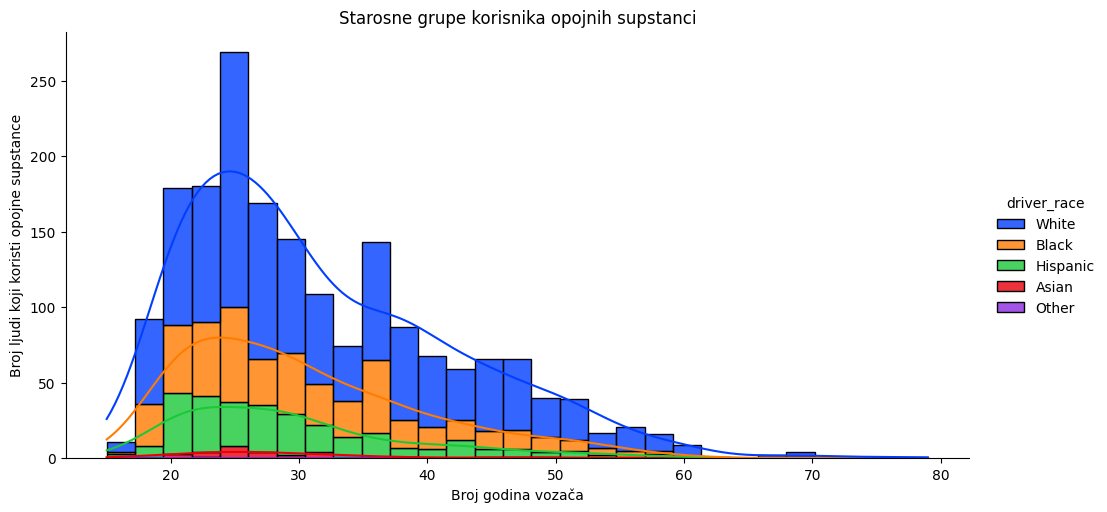

In [162]:
sns.displot(x='driver_age',data = data[data['is_arrested']==True],
            kde = True, hue = 'driver_race', multiple = "stack", alpha = 0.8, palette = "bright", height=5, aspect=2)
plt.title('Starosne grupe korisnika opojnih supstanci')
plt.xlabel("Broj godina vozača")
plt.ylabel("Broj ljudi koji koristi opojne supstance");

Za ljude u dvadesetim godinama, tj. starosne grupe između 20–30 godina, primećeno je da su mnogo više uključeni u konzumiranje droga i opojnih supstanci nego oni iz bilo koje druge starosne grupe. 

Ovo takođe daje težinu činjenici da su „droge“ važan element jednačine i da se moraju uzeti u obzir za predviđanje saobraćajnih prekršaja.

## Odnos pola vozača i konzumiranja opojnih supstanci

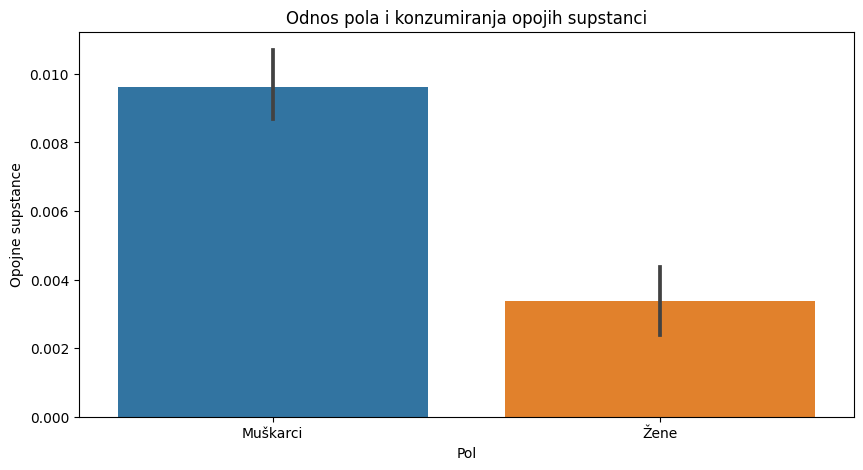

In [163]:
plt.figure(figsize=(10,5))
g = sns.barplot(x='driver_gender', y='drugs_related_stop', data=data)
g.set_xticklabels(['Muškarci', 'Žene'])
plt.title('Odnos pola i konzumiranja opojih supstanci')
plt.xlabel('Pol')
plt.ylabel('Opojne supstance')
plt.show()

## Odnos rase i konzumiranja opojnih supstanci

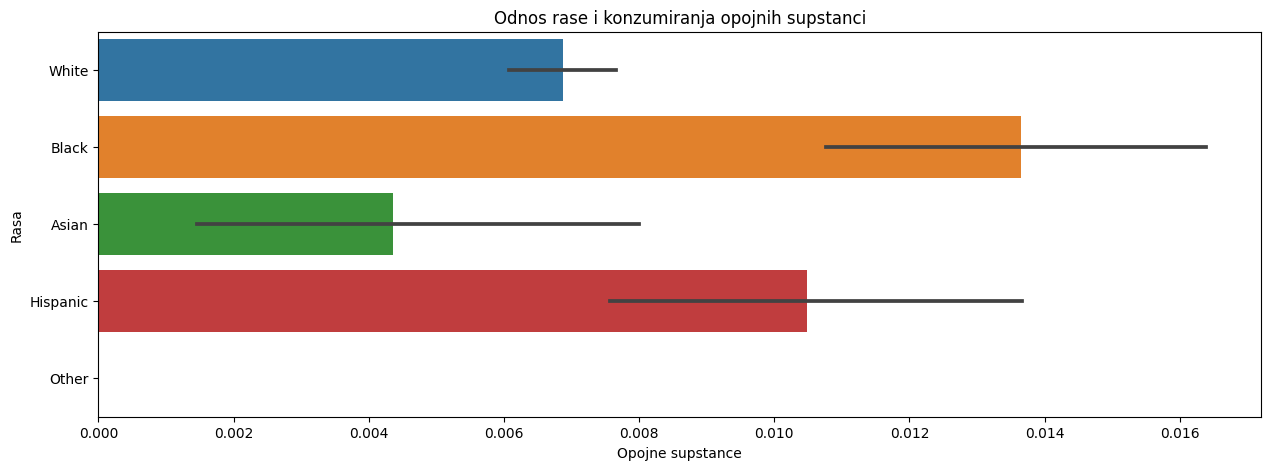

In [164]:
plt.figure(figsize=(15,5))
sns.barplot(x='drugs_related_stop', y='driver_race', data=data)
plt.title('Odnos rase i konzumiranja opojnih supstanci')
plt.ylabel('Rasa')
plt.xlabel('Opojne supstance')
plt.show()

## Odnos pola i trajanja intervencija

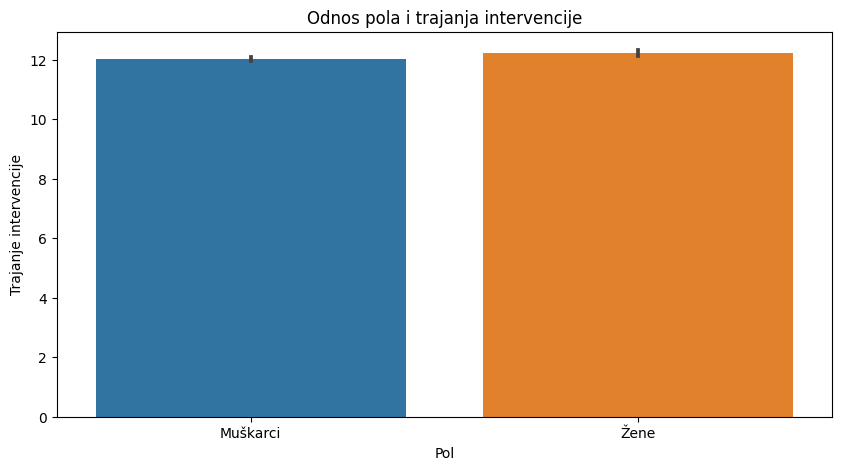

In [165]:
plt.figure(figsize=(10,5))
g = sns.barplot(x='driver_gender', y='stop_time', data=data)
g.set_xticklabels(['Muškarci', 'Žene'])
plt.title('Odnos pola i trajanja intervencije')
plt.xlabel('Pol')
plt.ylabel('Trajanje intervencije')
plt.show()

## Odnos pola i pretresa vozača

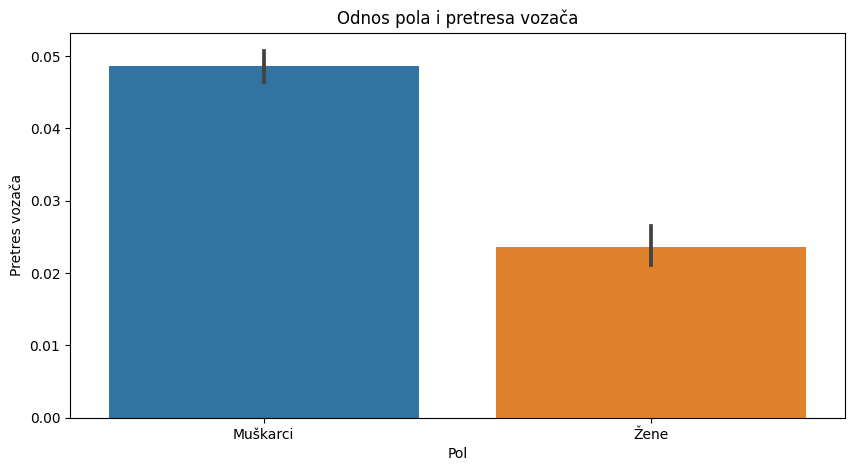

In [166]:
plt.figure(figsize=(10,5))
g = sns.barplot(x='driver_gender', y='search_conducted', data=data)
g.set_xticklabels(['Muškarci', 'Žene'])
plt.title('Odnos pola i pretresa vozača')
plt.xlabel('Pol')
plt.ylabel('Pretres vozača')
plt.show()

## Odnos pola i broja uhapšenih vozača

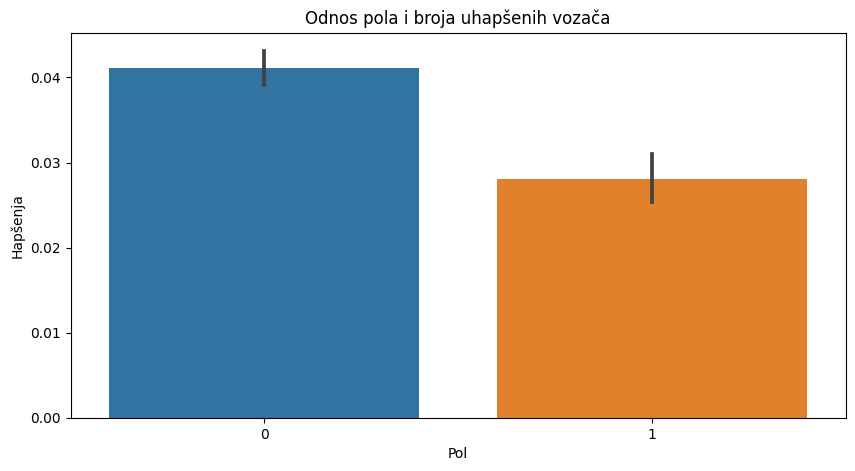

In [167]:
plt.figure(figsize=(10,5))
sns.barplot(x='driver_gender', y='is_arrested', data=data)
plt.title('Odnos pola i broja uhapšenih vozača')
plt.xlabel('Pol')
plt.ylabel('Hapšenja')
plt.show()

## Odnos rase i godina vozača

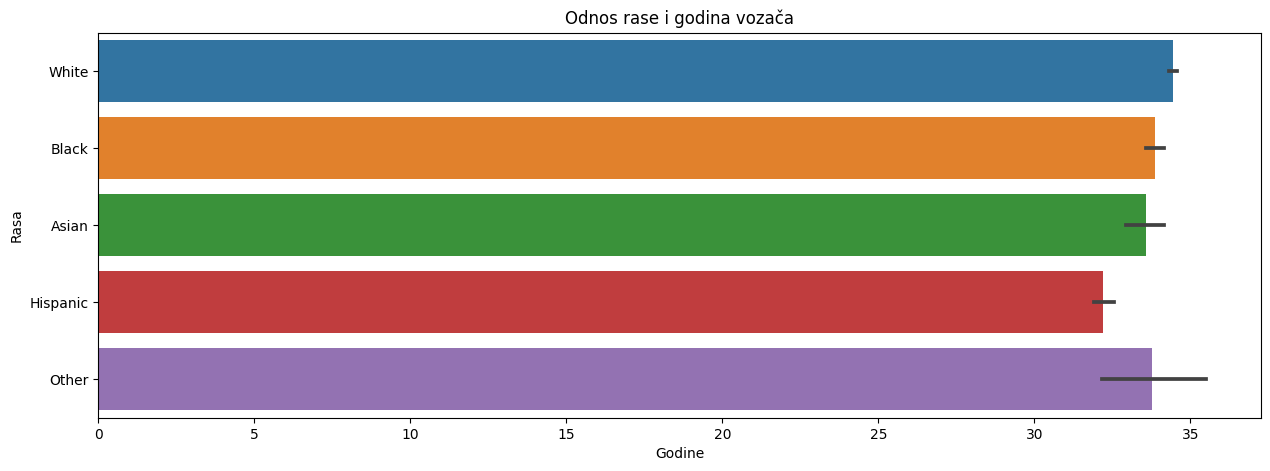

In [168]:
plt.figure(figsize=(15,5))
sns.barplot(x='driver_age', y='driver_race', data=data)
plt.title('Odnos rase i godina vozača')
plt.ylabel('Rasa')
plt.xlabel('Godine')
plt.show()

## Odnos rase i uhapšenih vozača

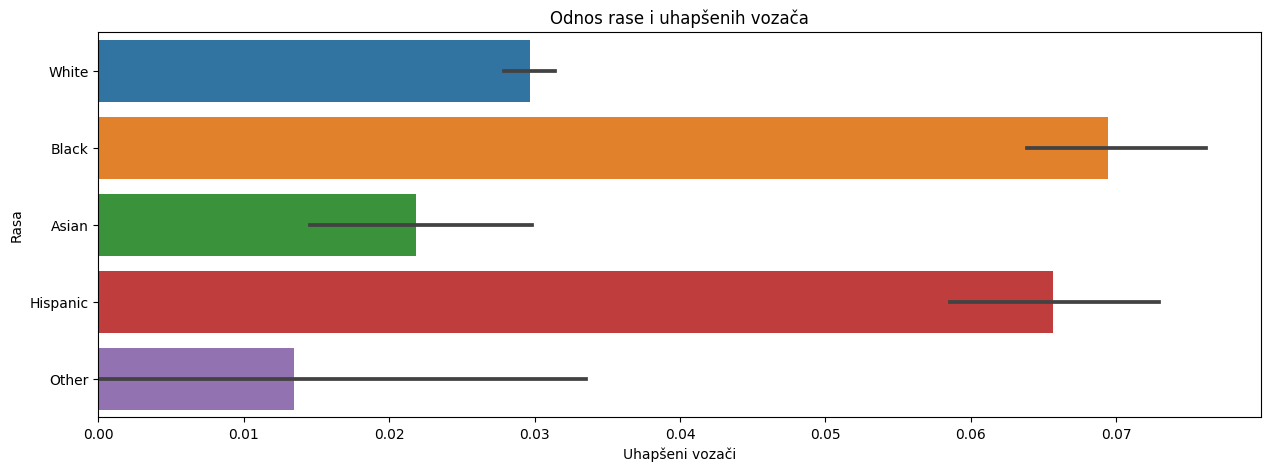

In [169]:
plt.figure(figsize=(15,5))
sns.barplot(x='is_arrested', y='driver_race', data=data)
plt.title('Odnos rase i uhapšenih vozača')
plt.ylabel('Rasa')
plt.xlabel('Uhapšeni vozači')
plt.show()

## Odnos rase i rezultata pretresa

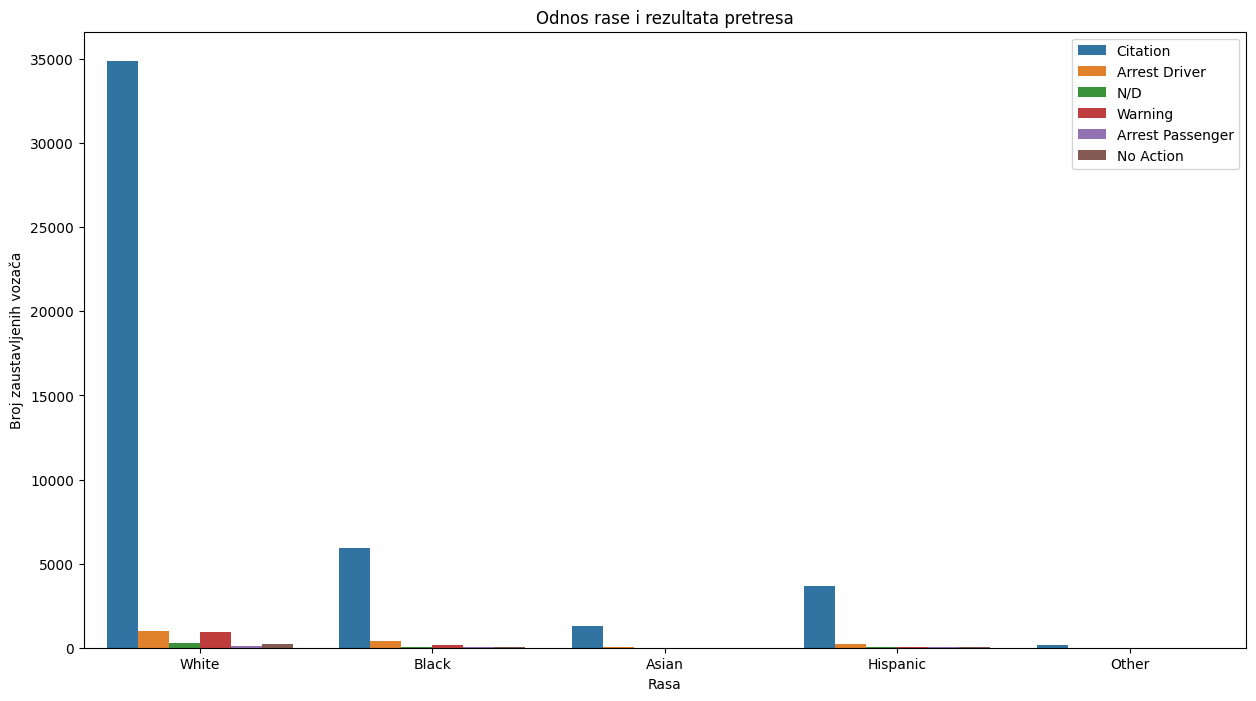

In [170]:
plt.figure(figsize=(15,8))
sns.countplot(x='driver_race', hue='stop_outcome', data=data)
plt.title('Odnos rase i rezultata pretresa')
plt.xlabel('Rasa')
plt.ylabel('Broj zaustavljenih vozača')
plt.legend(loc='upper right')
plt.show()

## Odnos rase i trajanja pretresa

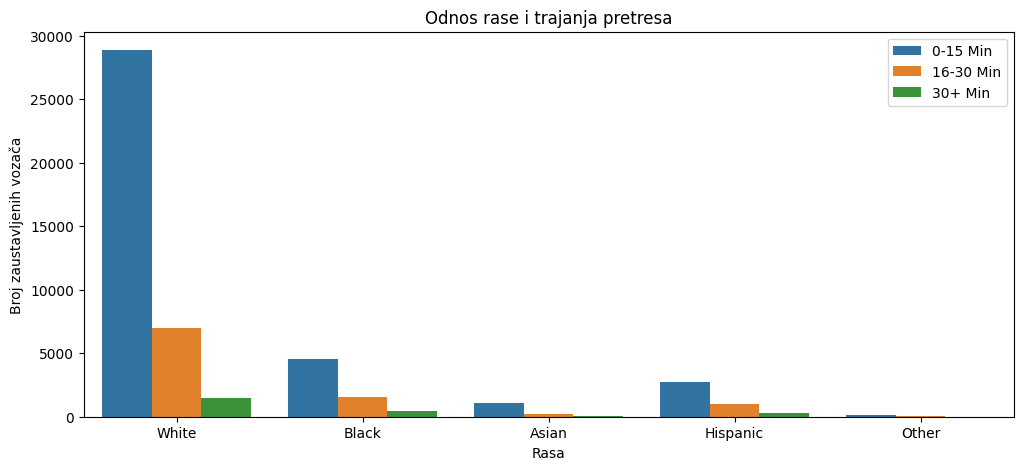

In [171]:
plt.figure(figsize=(12,5))
sns.countplot(x='driver_race', hue='stop_duration', data=data)
plt.title('Odnos rase i trajanja pretresa')
plt.xlabel('Rasa')
plt.ylabel('Broj zaustavljenih vozača')
plt.legend(loc='upper right')
plt.show()

## Da li su prekršioci uhapšeni nakon pretresa

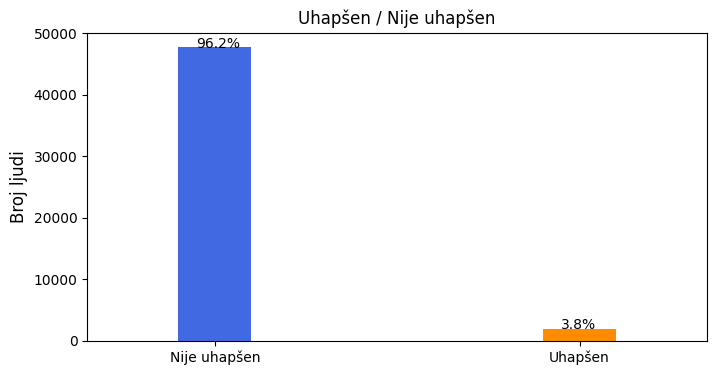

In [172]:
fig, ax = plt.subplots()
fig.canvas.draw()
data.is_arrested.value_counts().plot(kind="bar", width=0.2, figsize=(8, 4), color = ["royalblue","darkorange"])
plt.ylabel("Broj ljudi", fontsize=12)
plt.title("Uhapšen / Nije uhapšen")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100 * i.get_height()/len(data.is_arrested))
    x = i.get_x() + i.get_width() - 0.15
    y = i.get_height()
    ax.annotate(percentage, (x, y))
ax.set_xticklabels(["Nije uhapšen","Uhapšen"], rotation = 0);

Možemo videti da velika većina tj 96.2 % vozača nije privođeno nakon policijske intervencije.

## Toplotna mapa korelacija (Heatmap of variable correlations)

C:\Users\Stefan\AppData\Local\Temp\ipykernel_8068\118324886.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


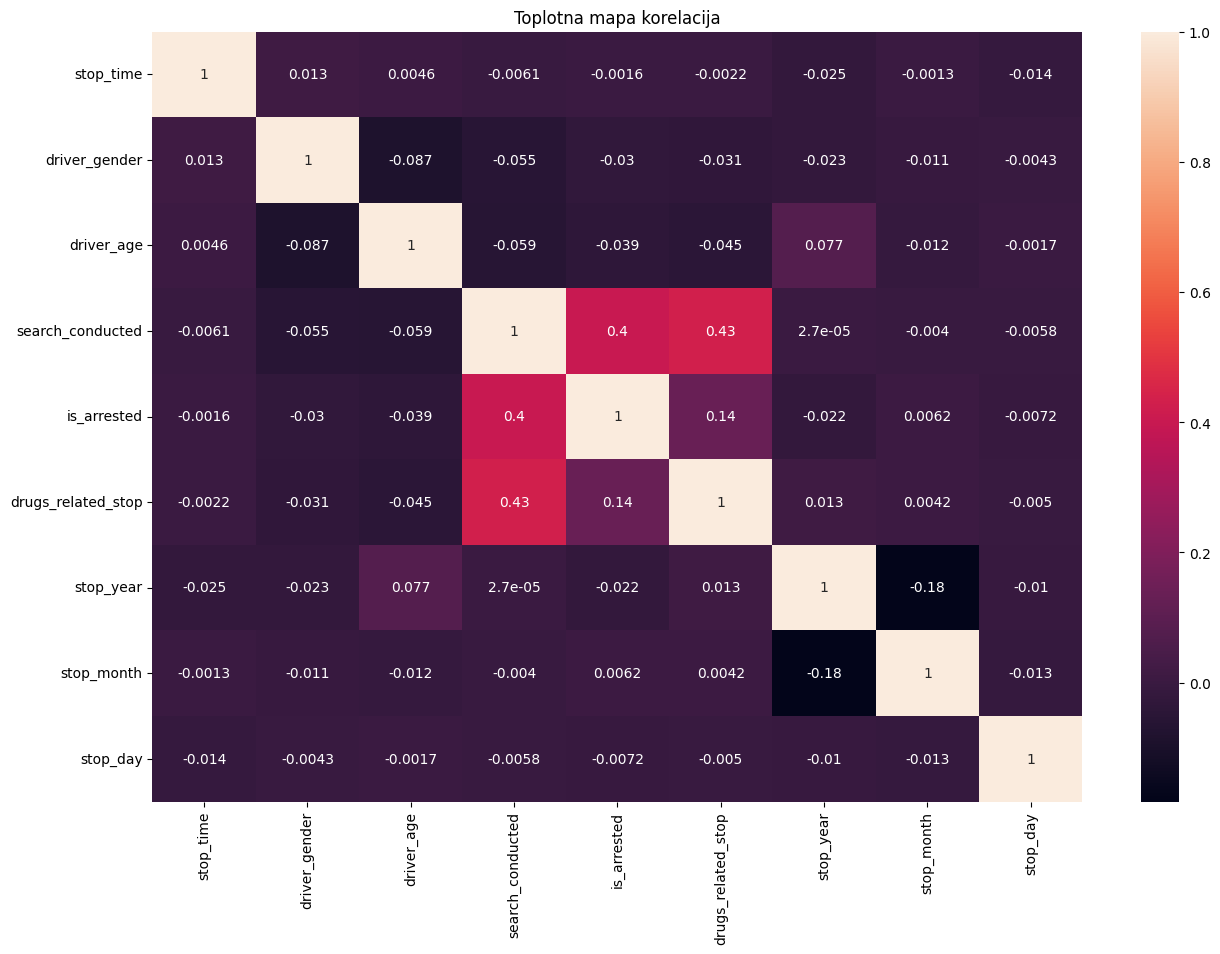

In [173]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), annot=True)
plt.title('Toplotna mapa korelacija')
plt.show()

# Priprema skupa podataka za klasifikaciju i klasterovanje

In [174]:
data.drop('stop_outcome', axis=1, inplace=True)
data.head()

,stop_time,driver_gender,driver_age,driver_race,violation,search_conducted,is_arrested,stop_duration,drugs_related_stop,stop_year,stop_month,stop_day
0,1.916667,0,20.0,White,Speeding,0,0,0-15 Min,0,2005,1,2
1,8.250000,0,40.0,White,Speeding,0,0,0-15 Min,0,2005,1,18
2,23.250000,0,33.0,White,Speeding,0,0,0-15 Min,0,2005,1,23
3,17.250000,0,19.0,White,Call for Service,0,1,16-30 Min,0,2005,2,20
4,10.000000,1,21.0,White,Speeding,0,0,0-15 Min,0,2005,3,14


In [175]:
temp = pd.get_dummies(data['driver_race'], drop_first=False)
data = pd.concat([data,temp], axis=1)
data.drop('driver_race', axis=1, inplace=True)

temp = pd.get_dummies(data['violation'], drop_first=False)
data = pd.concat([data,temp], axis=1)
data.drop('violation', axis=1, inplace=True)

temp = pd.get_dummies(data['stop_duration'], drop_first=False)
data = pd.concat([data,temp], axis=1)
data.drop('stop_duration', axis=1, inplace=True)

temp = pd.get_dummies(data['stop_year'], drop_first=False)
data = pd.concat([data,temp], axis=1)
data.drop('stop_year', axis=1, inplace=True)
data.head()

,stop_time,driver_gender,driver_age,search_conducted,is_arrested,drugs_related_stop,stop_month,stop_day,Asian,Black,...,0-15 Min,16-30 Min,30+ Min,2005,2006,2007,2008,2009,2010,2011
0,1.916667,0,20.0,0,0,0,1,2,0,0,...,1,0,0,1,0,0,0,0,0,0
1,8.250000,0,40.0,0,0,0,1,18,0,0,...,1,0,0,1,0,0,0,0,0,0
2,23.250000,0,33.0,0,0,0,1,23,0,0,...,1,0,0,1,0,0,0,0,0,0
3,17.250000,0,19.0,0,1,0,2,20,0,0,...,0,1,0,1,0,0,0,0,0,0
4,10.000000,1,21.0,0,0,0,3,14,0,0,...,1,0,0,1,0,0,0,0,0,0


In [176]:
data['is_arrested'].value_counts()

0    47711
1     1869
Name: is_arrested, dtype: int64

**Primećujemo da je klasa nebalansirana**

## Elementi van granica

In [177]:
def IQR(data, feature_names):
    
    iqr = pd.DataFrame(0, index=feature_names, columns=['lower', 'min', 'num_lower', 'upper', 'max', 'num_upper', 'percantage'])
    for name in feature_names:

        (Q1, Q3) = X[name].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        upper = Q3 + (1.5 * IQR)
        lower = Q1 - (1.5 * IQR)
        
        iqr.loc[name, 'upper'] = upper
        iqr.loc[name, 'lower'] = lower

        num_of_out_lower = (X[name] < lower).sum()
        num_of_out_upper = (X[name] > upper).sum()

        percentage = round((num_of_out_lower + num_of_out_upper) / X.shape[0] * 100)

        iqr.loc[name, 'num_lower'], iqr.loc[name, 'num_upper'], iqr.loc[name, 'percantage']  = num_of_out_lower, num_of_out_upper, percentage
        iqr.loc[name, 'min'], iqr.loc[name, 'max'] = min(X[name]), max(X[name])    
    return iqr

In [178]:
from sklearn.model_selection import train_test_split

X = data.copy(deep=True)
Y = data['is_arrested']

X.drop('is_arrested', axis=1, inplace=True)
feature_names = X.columns
X.head()

,stop_time,driver_gender,driver_age,search_conducted,drugs_related_stop,stop_month,stop_day,Asian,Black,Hispanic,...,0-15 Min,16-30 Min,30+ Min,2005,2006,2007,2008,2009,2010,2011
0,1.916667,0,20.0,0,0,1,2,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,8.250000,0,40.0,0,0,1,18,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,23.250000,0,33.0,0,0,1,23,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,17.250000,0,19.0,0,0,2,20,0,0,0,...,0,1,0,1,0,0,0,0,0,0
4,10.000000,1,21.0,0,0,3,14,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [179]:
Y.unique()

array([0, 1], dtype=int64)

Vrednost 0 označava da osoba nije uhapšena, a 1 suprotno. Rešavamo problem binarne klasifikacije.

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=23)

In [181]:
X_IQR = IQR(X_train, feature_names)
X_IQR

,lower,min,num_lower,upper,max,num_upper,percantage
stop_time,-4.508333,0,0,29.158333,23.983333,0,0
driver_gender,-1.500000,0,0,2.500000,1.000000,0,0
driver_age,-7.000000,15,0,73.000000,88.000000,153,0
search_conducted,0.000000,0,0,0.000000,1.000000,2085,4
drugs_related_stop,0.000000,0,0,0.000000,1.000000,396,1
stop_month,-6.000000,1,0,18.000000,12.000000,0,0
stop_day,-14.500000,1,0,45.500000,31.000000,0,0
Asian,0.000000,0,0,0.000000,1.000000,1375,3
Black,0.000000,0,0,0.000000,1.000000,6594,13
Hispanic,0.000000,0,0,0.000000,1.000000,4099,8


Vidimo da postoje autlajeri u našem skupu, ali da li će oni uticati na rad modela?
Ne bi trebalo iz razloga što su osobe bele rase najzastupljenije na području sa koga su zabeleženi podaci.
Takodje, policijske intervencije u vremenskim intervalima do 30 minuta mogu zavisiti od mnogo faktora, što nije naročito neočigledno.
Dodatno, godine u kojima su registrovane saobraćajne nezgode su tako raspoređene da je najviše podataka prikupljeno na samom početku vođenja intervencije i da opada kako godine rastu.

Konvertujemo imena atributa u stringovnu reprezentaciju kako bi omogućili treniranje modela i primenu standardizacije.

In [182]:
X.columns = X.columns.astype(str)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [183]:
from joblib import dump
dump((X_train, X_test, Y_train, Y_test), 'classification_dataset.joblib')

['classification_dataset.joblib']

In [184]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled, columns=X.columns)
dump((X, Y), 'clustering_dataset.joblib')

['clustering_dataset.joblib']